In [138]:
import cv2
import numpy as np
import pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,confusion_matrix,multilabel_confusion_matrix,recall_score

In [121]:
cv2.__version__
import sklearn
sklearn.__version__

'0.23.1'

Let us first read the train and test files

In [3]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

In [4]:
train_images_filenames[12]

'../../Databases/MIT_split/train/Opencountry/fie26.jpg'

We create a SIFT object detector and descriptor

In [5]:
SIFTdetector = cv2.SIFT_create(nfeatures=300)

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [6]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

We now compute a k-means clustering on the descriptor space

In [33]:
# k = 128
k=128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2560, compute_labels=False, n_clusters=128,
                random_state=42, reassignment_ratio=0.0001, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [34]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors

In [261]:
knn = KNeighborsClassifier(n_neighbors=14,n_jobs=-1,metric='minkowski')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(n_jobs=-1, n_neighbors=14)

We end up computing the test descriptors and compute the accuracy of the model

In [262]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [263]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)
scores = cross_val_score(knn, visual_words_test, test_labels, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 200))

57.62081784386617
[0.46296296 0.5308642  0.48447205 0.53416149 0.46583851]
Accuracy: 49.57 (+/- 6.20)


## My own code

In [144]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)
# print(precision)
y_pred= knn.predict(visual_words_test)
precision=100*precision_score(y_pred, test_labels,average='macro')
recall=100*recall_score(y_pred, test_labels,average='macro')
print(precision,recall)

56.877323420074354
57.14529120333209 59.115441921219094


In [145]:
import pandas as pd

In [207]:
def run_different_knn(neigh,metric):
    knn = KNeighborsClassifier(n_neighbors=neigh,n_jobs=-1,metric=metric)
    knn.fit(visual_words, train_labels)
    
    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        all_staff=[]
        for part in range(0,4):
            h,w=gray.shape
            temp=gray[h//part:h//3]
            kpt,des=SIFTdetector.detectAndCompute(gray,None)
            words=codebook.predict(des)
            all_staff.append(np.bincount(words,minlength=k))
        
        visual_words_test[i,:]=np.concatenate(all_staff)
        #check contatenate and tiling
    
    accuracy = 100*knn.score(visual_words_test, test_labels)
    y_pred= knn.predict(visual_words_test)
    precision=100*precision_score(y_pred, test_labels,average='macro')
    recall=100*recall_score(y_pred, test_labels,average='macro')
    
    return precision,recall,accuracy

DENSE SIFT

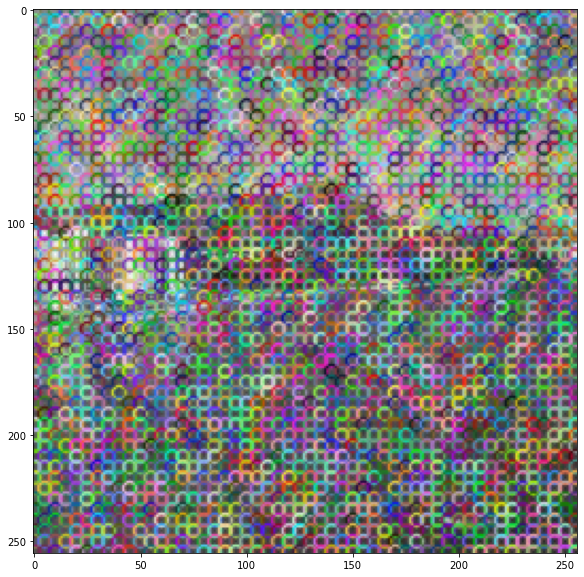

In [5]:
import skimage.data as skid
import cv2
import pylab as plt

img = cv2.imread(r'C:/Users/adama/OneDrive/Dokumenty/Master of Computer Vision/M3/Databases/MIT_split/train/coast/art294.jpg')
gray= cv2.cvtColor(img ,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create(nfeatures=300)

step_size = 5
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                    for x in range(0, gray.shape[1], step_size)]

img=cv2.drawKeypoints(gray,kp, img)

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

# dense_feat = sift.compute(gray, kp)

In [278]:
test=np.array([[0,0,0,0],[1,1,1,1],[2,2,2,2]])
print(test,"-----------\n")
print(test[0:h//3])
print(test.shape)
h,w=test.shape
print(h)

[[0 0 0 0]
 [1 1 1 1]
 [2 2 2 2]] -----------

[[0 0 0 0]]
(3, 4)
3


In [244]:
data_confusion=[]
metric=['euclidean','manhattan','chebyshev','minkowski']
from datetime import datetime

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(dt_string)
for item in range(22,32,2):
    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing knn={item}")
    for m in metric:
        precision,recall,accuracy=run_different_knn(item,m)
        data_confusion.append([item,precision,recall,m])
today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} finished")
df=pd.DataFrame(data_confusion, columns=['knn','precision','recall','metric'])

15:21:34
15:21:34 started doing knn=22
15:22:41 started doing knn=24
15:23:49 started doing knn=26
15:25:03 started doing knn=28
15:26:14 started doing knn=30
15:27:25 finished


In [245]:
df_22_30=df

In [241]:
df_2_20=df

In [256]:
df=pd.DataFrame()
df=df.append(df_2_20,ignore_index=True)

In [258]:
df.append(df_22_30,ignore_index=True)

,knn,precision,recall,metric
0,2,47.004050,52.358469,euclidean
1,2,43.222395,50.559943,manhattan
2,2,36.326835,41.281060,chebyshev
3,2,47.004050,52.358469,minkowski
4,4,52.821059,55.864599,euclidean
5,4,50.372591,52.905607,manhattan
6,4,42.650057,46.329312,chebyshev
7,4,52.821059,55.864599,minkowski
8,6,54.426481,56.532547,euclidean
9,6,50.381544,52.796967,manhattan


In [1]:
print(df)
# df['precision']=df['precision']/100
# df['recall']=df['recall']/100
df_eucl=df.metric=='euclidean'
df[df_eucl].plot.scatter(x='precision',y='recall',xlim=(0,1),ylim=(0,1),cmap='viridis')

NameError: name 'df' is not defined

    knn  precision     recall     metric
0     2  47.004050  52.358469  euclidean
1     2  43.222395  50.559943  manhattan
2     2  36.326835  41.281060  chebyshev
3     2  47.004050  52.358469  minkowski
4     4  52.821059  55.864599  euclidean
5     4  50.372591  52.905607  manhattan
6     4  42.650057  46.329312  chebyshev
7     4  52.821059  55.864599  minkowski
8     6  54.426481  56.532547  euclidean
9     6  50.381544  52.796967  manhattan
10    6  43.299894  47.392108  chebyshev
11    6  54.426481  56.532547  minkowski
12    8  54.266079  57.154409  euclidean
13    8  51.125793  52.053346  manhattan
14    8  44.948018  48.277197  chebyshev
15    8  54.266079  57.154409  minkowski
16   10  57.145291  59.115442  euclidean
17   10  51.218205  53.423052  manhattan
18   10  45.915137  48.704480  chebyshev
19   10  57.145291  59.115442  minkowski
20   12  56.220509  58.548059  euclidean
21   12  52.530659  53.096007  manhattan
22   12  44.435129  47.428556  chebyshev
23   12  56.2205

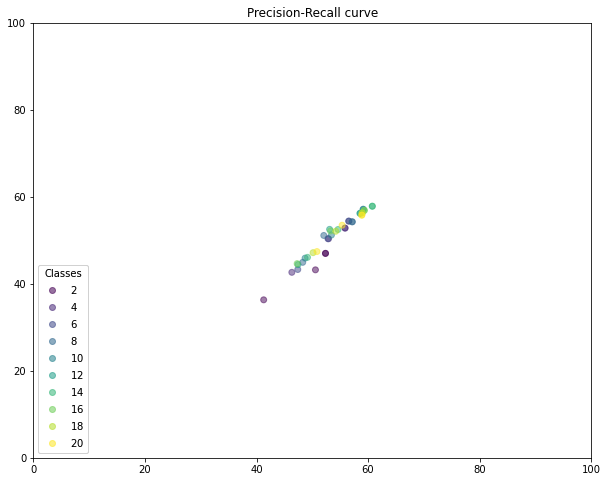

In [260]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Precision-Recall curve', xlim=(0,100), ylim=(0,100))

df2=df[df]
print(df2)
print("max\n",df2[df.precision==df2.precision.max()])
print(df2[df.recall==df2.recall.max()])
scatter=ax.scatter(df2.recall, df2.precision, c=df2.knn,
           label=df2.knn,
           marker='o', alpha=.5,
           cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

In [160]:
df['precision']=df['precision']*100

Dimensionality reduction, with PCA and LDA

In [60]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

55.14250309789344


In [88]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

59.727385377943


In [64]:
len(visual_words)

1881

In [65]:
len(train_labels)

1881